# Housing prices for King County

Training a simple polynomial model on Hosing Sale data from king country [data source](https://www.kaggle.com/datasets/harlfoxem/housesalesprediction)
As a learning exercise

In [1]:
from utils import load_data
from train import compute_cost, compute_gradient, gradient_descent
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
# Data is a pandas DataFrame
data = load_data.load_data("./data/kc_house_data.csv")


# Feature Engineering
Housing prices do not tend to be linear but curve like, thus we will be engineering some polynomial features

In [2]:
labels = data['price']
data.drop(['price', 'date', 'id', 'lat', 'long'], axis=1, inplace=True)
dataSquared = data.pow(2)
dataSquared.rename(lambda c: f"{c} squared", inplace=True, axis='columns')

dataCubed = data.pow(3)
dataCubed.rename(lambda c: f"{c} cubed", inplace=True, axis='columns')

engineeredData = data.join(dataSquared).join(dataCubed)

engineeredData[0:5]

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,view cubed,condition cubed,grade cubed,sqft_above cubed,sqft_basement cubed,yr_built cubed,yr_renovated cubed,zipcode cubed,sqft_living15 cubed,sqft_lot15 cubed
0,3,1.00,1180,5650,1.0,0,0,3,7,1180,...,0,27,343,1643032000,0,7472058875,0,946329856735752,2406104000,180362125000
1,3,2.25,2570,7242,2.0,0,0,3,7,2170,...,0,27,343,10218313000,64000000,7426288351,7892485271,944798095703125,4826809000,445768658119
2,2,1.00,770,10000,1.0,0,0,3,6,770,...,0,27,216,456533000,0,7222633237,0,941998966517952,20123648000,523996494328
3,4,3.00,1960,5000,1.0,0,0,5,7,1050,...,0,125,343,1157625000,753571000,7587307125,0,945115872339456,2515456000,125000000000
4,3,2.00,1680,8080,1.0,0,0,3,8,1680,...,0,27,512,4741632000,0,7845011803,0,943325698349224,5832000000,422381452527


# Feature Scaling


In [3]:
means = engineeredData.mean()
stds = engineeredData.std()
for column in engineeredData.columns:
    engineeredData[column] = engineeredData[column] - means[column]
    engineeredData[column] = engineeredData[column] / stds[column]


# Training Data
We have split the data into two halves, the first half will be the training data. Matrix trainingSamples contains our examples. Each row is an example and each column is a feature. Vector trainingLabels contains the labels for our training set.

In [4]:
total_rows = len(engineeredData)
trainingSetRows = total_rows // 2
trainingSamples = engineeredData[0:trainingSetRows].copy()
trainingLabels = labels[0:trainingSetRows].copy()

print(f"trainingSamples shape: {trainingSamples.shape}")
print(f"trainingLabels shape: {trainingLabels.shape}")

trainingSamples shape: (10806, 48)
trainingLabels shape: (10806,)


# Parameters
Parameter vector w and param b


In [5]:
b = 1
w = np.random.random_sample(trainingSamples.shape[1])
print(f"w shape: {w.shape}")
print(f"Initial cost: {compute_cost(trainingSamples.to_numpy(), trainingLabels.to_numpy(), w, b)}")
dj_dw, dj_db = compute_gradient(trainingSamples.to_numpy(), trainingLabels.to_numpy(), w, b)
print(f"Initial gradient dw:  {dj_dw})")
print(f"Initial gradient db: {dj_db})")

w shape: (48,)
Initial cost: 210743364304.52267
Initial gradient dw:  [-103589.01513766 -153862.47723057 -239722.52577471  -47834.84297685
  -36567.03965963 -111840.47935325 -151508.65128857  -46279.10493238
 -211648.37544476 -194626.89947774 -133315.67860678   53747.81186333
  -62254.52911746   19497.79296018 -204176.48144148  -40856.76969629
  -68695.50236019 -178037.34495316 -263867.83479226  -22902.57394302
  -28080.43633328 -111840.47935325 -149754.40985325  -46044.4209495
 -221681.99797736 -212961.94428687 -165008.43949415   53863.85230424
  -62434.93042367   19500.29155917 -206861.24051979  -12390.3957102
  -13177.04149996 -192428.13981855 -247826.74716075  -16193.58362898
  -17528.67696699 -111840.47935325 -142978.12462902  -45728.55734225
 -229645.31301536 -215239.47787519 -159344.81283127   53981.27941022
  -62609.17701246   19502.79057458 -198303.4549921    -6148.41321522])
Initial gradient db: -531754.3131574342)


In [6]:
# Run gradient descent
alpha = 5.0e-4
iterations = 1_00_000
w_final, b_final, j_history = gradient_descent(trainingSamples.to_numpy(), trainingLabels.to_numpy(), w, b, compute_cost, compute_gradient, alpha, iterations)
print(f"Final cost: {compute_cost(trainingSamples.to_numpy(), trainingLabels.to_numpy(), w_final, b_final)}")


Iteration    0: Cost 210150492390.57   
Iteration  100: Cost 169203812599.43   
Iteration  200: Cost 146724538564.35   
Iteration  300: Cost 131134429872.04   
Iteration  400: Cost 118805883623.97   
Iteration  500: Cost 108433169321.17   
Iteration  600: Cost 99445487560.23   
Iteration  700: Cost 91537122665.86   
Iteration  800: Cost 84515649717.23   
Iteration  900: Cost 78245983792.84   
Iteration 1000: Cost 72626238095.81   
Iteration 1100: Cost 67575681270.98   
Iteration 1200: Cost 63028042850.33   
Iteration 1300: Cost 58927504368.21   
Iteration 1400: Cost 55226164099.70   
Iteration 1500: Cost 51882357599.58   
Iteration 1600: Cost 48859495055.32   
Iteration 1700: Cost 46125221046.20   
Iteration 1800: Cost 43650782025.60   
Iteration 1900: Cost 41410532380.01   
Iteration 2000: Cost 39381536481.47   
Iteration 2100: Cost 37543239879.96   
Iteration 2200: Cost 35877192226.55   
Iteration 2300: Cost 34366810275.38   
Iteration 2400: Cost 32997172887.01   
Iteration 2500: Cos

# Plotting cost vs iterations


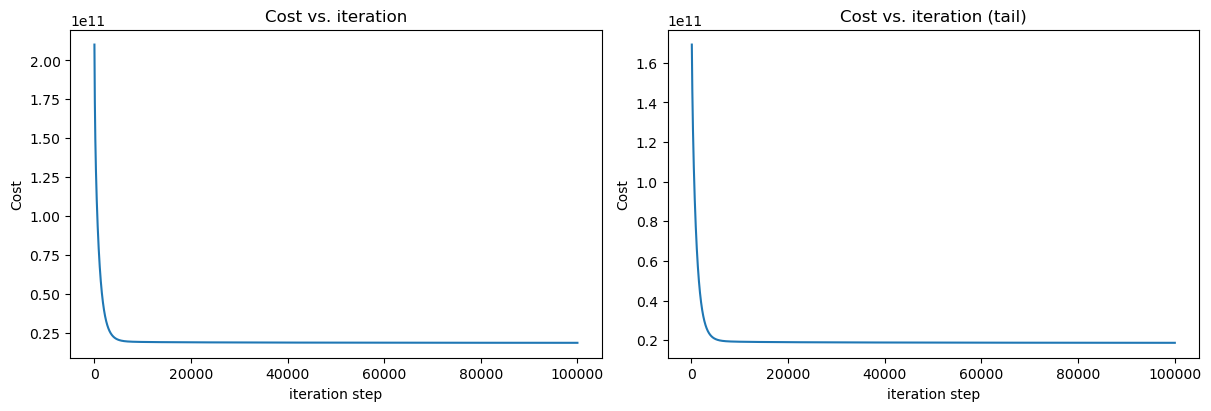

In [7]:


fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))
ax1.plot(j_history)
ax2.plot(100 + np.arange(len(j_history[100:])), j_history[100:])
ax1.set_title("Cost vs. iteration");  ax2.set_title("Cost vs. iteration (tail)")
ax1.set_ylabel('Cost')             ;  ax2.set_ylabel('Cost')
ax1.set_xlabel('iteration step')   ;  ax2.set_xlabel('iteration step')
plt.show()

In [8]:
print(f"w final: {w_final}")

w final: [-2.94483351e+03  1.49323769e+04 -2.37040156e+02 -1.03380587e+04
 -8.91407519e+03  1.67815557e+04  8.64285856e+03  3.72359437e+01
  3.13567420e+04 -7.43106928e+03  1.34125046e+04 -3.41389821e+04
 -2.83979031e+03 -1.36011794e+03  5.25520231e+04 -3.36762940e+04
 -1.07901241e+04  1.86503953e+04  5.98286613e+04  2.48341079e+04
  5.67428227e+03  1.67814428e+04 -1.20143391e+02  4.91216222e+03
  4.80415932e+04 -3.72803579e+04 -1.40729613e+04 -3.31624538e+04
  2.67184661e+03 -1.50738406e+03  2.39090496e+04  5.13943109e+04
 -7.29198251e+03 -2.07866032e+03  1.35679602e+05 -1.46844090e+04
  2.55279776e+04  1.67815847e+04  1.96500058e+04  1.27978917e+04
  6.58808133e+04  7.98072386e+03 -2.13373279e+04 -3.21145956e+04
  8.14508115e+03 -1.65494741e+03 -2.72148495e+04 -3.72073176e+04]
